## V8_MODEL_stacking_3 (xgb+lgb+rf+gb+en)

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [3]:
v8: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"V8.csv"))

In [4]:
pd.set_option('display.max_columns', None)
v8

,index,_type,area_price,area_m2_price,original_index,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,built_year,latitude,longitude,age,contract_0,contract_1,deposit,apt_idx,area,grid_id,nearest_subway_distance,nearest_subway_idx,nearest_park_distance,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area
0,0,train,658.914729,200.004471,0,201906,25,84.9981,20190625,9,2019,37.054314,127.045216,0,False,False,17000.0,0,25.8,25581.836691,717,40,498.618918,7683,29300,NaN,9759,6739,156.120431,3898.0
1,1,train,891.472868,270.594284,1,202003,26,84.9981,20200326,20,2019,37.054314,127.045216,1,False,False,23000.0,0,25.8,25581.836691,717,40,498.618918,7683,29300,17000.0,9759,6739,156.120431,3898.0
2,2,train,891.472868,270.594284,2,202003,28,84.9981,20200328,8,2019,37.054314,127.045216,1,False,False,23000.0,0,25.8,25581.836691,717,40,498.618918,7683,29300,23000.0,9759,6739,156.120431,3898.0
3,3,train,277.777778,84.260195,3,201907,15,59.3400,20190715,1,1986,36.964647,127.055847,33,False,False,5000.0,1,18.0,18375.213675,3897,41,169.839678,18366,58901,NaN,9139,6535,214.559689,1616.0
4,4,train,99.447514,30.095302,4,201904,12,59.8100,20190412,6,1995,36.972390,127.084514,24,False,False,1800.0,2,18.1,12627.879781,2039,41,382.401815,18369,58863,NaN,9201,6589,1708.489263,3986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,test,NaN,NaN,150167,202402,27,115.5101,20240227,17,2010,37.528394,126.659398,14,True,False,NaN,17869,35.0,33310.656662,1483,650,398.113485,6088,25360,37000.0,14160,9387,224.754177,8963.9
1951396,150168,test,NaN,NaN,150168,202403,2,142.8738,20240302,4,2010,37.528394,126.659398,14,True,False,NaN,17869,43.3,33310.656662,1483,650,398.113485,6088,17911,43000.0,14160,9387,224.754177,8963.9
1951397,150169,test,NaN,NaN,150169,202403,16,142.8738,20240316,13,2010,37.528394,126.659398,14,False,True,NaN,17869,43.3,33310.656662,1483,650,398.113485,6088,17911,43000.0,14160,9387,224.754177,8963.9
1951398,150170,test,NaN,NaN,150170,202403,22,114.9285,20240322,2,2010,37.528394,126.659398,14,False,True,NaN,17869,34.8,33310.656662,1483,650,398.113485,6088,24128,32500.0,14160,9387,224.754177,8963.9


### 컬럼 정리

In [5]:
# columns_to_drop = ['contract_2', 'area_m2_price', 'area_price', 'date', 'contract_ymd', 'original_index', 'interest_rate', 'diff_interest_rate', 'area']
# df = v4_arima_contract_type.drop(columns=columns_to_drop, errors='ignore')

# columns = ['index', 'area_m2', 'floor', 'age', 'latitude', 'longitude', 'apt_idx','nearest_subway_distance', 'category_interchange_within_1km',
#            'deposit', '_type', 'grid_id', 'apt_deposit_rank', 'apt_area_deposit_rank', 'recent_deposit', 
#            'contract_year_month', 'contract_0', 'contract_1', 'infra_score']

columns = ['index','_type',
    'area_m2', 'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'nearest_park_idx',
    'nearest_school_idx',
    'nearest_school_distance',
    'park_area',]
df = v8.filter(items=columns)

df['recent_deposit'] = df['recent_deposit'].fillna(39000)
temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

In [6]:
from sklearn.preprocessing import StandardScaler

# 로그 변환할 컬럼들
columns_to_log_transform = [col for col in df.columns if col not in ['index', 'contract_0', 'contract_1', 'deposit', '_type']]

# 0이하값 0으로 변환
df['floor'] = df['floor'].clip(lower=0)
df['age'] = df['age'].clip(lower=0)

# 로그 변환
for col in columns_to_log_transform:
    df[col] = np.log1p(df[col])

df

,index,_type,area_m2,contract_date_numeric,floor,built_year,latitude,longitude,age,contract_0,contract_1,deposit,apt_idx,area,grid_id,nearest_subway_distance,nearest_subway_idx,nearest_park_distance,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area
0,0,train,4.454325,16.820729,2.302585,7.610853,3.639014,4.852383,0.000000,False,False,17000.0,0.000000,3.288402,10.149677,6.576470,3.713572,6.213846,8.946896,10.285377,10.571343,9.186048,8.815815,5.057013,8.268475
1,1,train,4.454325,16.821209,3.044522,7.610853,3.639014,4.852383,0.693147,False,False,23000.0,0.000000,3.288402,10.149677,6.576470,3.713572,6.213846,8.946896,10.285377,9.741027,9.186048,8.815815,5.057013,8.268475
2,2,train,4.454325,16.821209,2.197225,7.610853,3.639014,4.852383,0.693147,False,False,23000.0,0.000000,3.288402,10.149677,6.576470,3.713572,6.213846,8.946896,10.285377,10.043293,9.186048,8.815815,5.057013,8.268475
3,3,train,4.099995,16.820733,0.693147,7.594381,3.636655,4.852466,3.526361,False,False,5000.0,0.693147,2.944439,9.818812,8.268219,3.737670,5.140726,9.818311,10.983630,10.571343,9.120416,8.785081,5.373238,7.388328
4,4,train,4.107754,16.820718,1.945910,7.598900,3.636859,4.852690,3.218876,False,False,1800.0,1.098612,2.949688,9.443742,7.620705,3.737670,5.949084,9.818474,10.982985,10.571343,9.127176,8.793309,7.443950,8.290794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,test,4.757978,16.823183,2.890372,7.606387,3.651395,4.849366,2.708050,True,False,NaN,9.790879,3.583519,10.413663,7.302496,6.478510,5.989246,8.714239,10.140968,10.518700,9.558247,9.147188,5.419447,9.101072
1951396,150168,test,4.968937,16.823186,1.609438,7.606387,3.651395,4.849366,2.708050,True,False,NaN,9.790879,3.790985,10.413663,7.302496,6.478510,5.989246,8.714239,9.793226,10.668979,9.558247,9.147188,5.419447,9.101072
1951397,150169,test,4.968937,16.823187,2.639057,7.606387,3.651395,4.849366,2.708050,False,True,NaN,9.790879,3.790985,10.413663,7.302496,6.478510,5.989246,8.714239,9.793226,10.668979,9.558247,9.147188,5.419447,9.101072
1951398,150170,test,4.752974,16.823187,1.098612,7.606387,3.651395,4.849366,2.708050,False,True,NaN,9.790879,3.577948,10.413663,7.302496,6.478510,5.989246,8.714239,10.091170,10.389026,9.558247,9.147188,5.419447,9.101072


In [7]:
# Standard Scaler 적용
scaler = StandardScaler()

# train 데이터에 fit_transform
train_data = df[df['_type'] == 'train']
df.loc[df['_type'] == 'train', columns_to_log_transform] = scaler.fit_transform(train_data[columns_to_log_transform])

# test 데이터에 transform
test_data = df[df['_type'] == 'test']
df.loc[df['_type'] == 'test', columns_to_log_transform] = scaler.transform(test_data[columns_to_log_transform])

df.head()

,index,_type,area_m2,contract_date_numeric,floor,built_year,latitude,longitude,age,contract_0,contract_1,deposit,apt_idx,area,grid_id,nearest_subway_distance,nearest_subway_idx,nearest_park_distance,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area
0,0,train,0.505180,-1.678760,0.161971,1.324663,-2.611122,0.464754,-2.703789,False,False,17000.0,-8.090443,0.509388,-0.699665,-0.163594,-1.669367,1.248634,0.304081,0.312334,0.324738,-2.198149,-2.045474,-0.924907,0.072085
1,1,train,0.505180,-0.961067,1.246423,1.324663,-2.611122,0.464754,-1.976285,False,False,23000.0,-8.090443,0.509388,-0.699665,-0.163594,-1.669367,1.248634,0.304081,0.312334,-1.078812,-2.198149,-2.045474,-0.924907,0.072085
2,2,train,0.505180,-0.960919,0.007970,1.324663,-2.611122,0.464754,-1.976285,False,False,23000.0,-8.090443,0.509388,-0.699665,-0.163594,-1.669367,1.248634,0.304081,0.312334,-0.567868,-2.198149,-2.045474,-0.924907,0.072085
3,3,train,-0.493075,-1.672100,-2.190464,-1.635972,-3.168942,0.527197,0.997359,False,False,5000.0,-7.436703,-0.500101,-1.461192,1.618782,-1.646066,-0.212067,1.259215,1.160771,0.324738,-2.656154,-2.272518,-0.300279,-0.524344
4,4,train,-0.471215,-1.694522,-0.359363,-0.823677,-3.120722,0.695555,0.674633,False,False,1800.0,-7.054289,-0.484695,-2.324466,0.936581,-1.646066,0.888247,1.259394,1.159986,0.324738,-2.608977,-2.211736,3.789915,0.087210


In [8]:
temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

## Model

In [9]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [35]:
# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 및 테스트 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']
X_test = test_df[feature_columns]

# 학습 데이터를 검증용으로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20)

### XGBOOST

In [11]:
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# XGBoost 파라미터 설정
xgb_params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 모델 학습
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    verbose_eval=25
)

# 검증 및 테스트 세트에 대한 예측
xgb_val_pred = xgb_model.predict(dval)
xgb_test_pred = xgb_model.predict(dtest)

[0]	train-mae:16480.02225	eval-mae:16481.82849
[25]	train-mae:7140.70680	eval-mae:7132.57952
[50]	train-mae:4780.08251	eval-mae:4766.41679
[75]	train-mae:4328.76278	eval-mae:4319.88379
[100]	train-mae:4205.47184	eval-mae:4199.48858
[125]	train-mae:4142.87096	eval-mae:4139.92869
[150]	train-mae:4096.50287	eval-mae:4096.44444
[175]	train-mae:4055.59475	eval-mae:4057.43262
[200]	train-mae:4030.28760	eval-mae:4033.95826
[225]	train-mae:4006.79689	eval-mae:4011.82861
[250]	train-mae:3987.47104	eval-mae:3993.49233
[275]	train-mae:3970.69889	eval-mae:3977.85323
[300]	train-mae:3954.21196	eval-mae:3962.07985
[325]	train-mae:3939.48120	eval-mae:3947.97176
[350]	train-mae:3928.74987	eval-mae:3938.08441
[375]	train-mae:3917.93508	eval-mae:3928.16644
[400]	train-mae:3909.41144	eval-mae:3920.44426
[425]	train-mae:3901.35874	eval-mae:3913.13601
[450]	train-mae:3894.86626	eval-mae:3907.21858
[475]	train-mae:3886.29266	eval-mae:3899.51401
[499]	train-mae:3878.31731	eval-mae:3892.58972


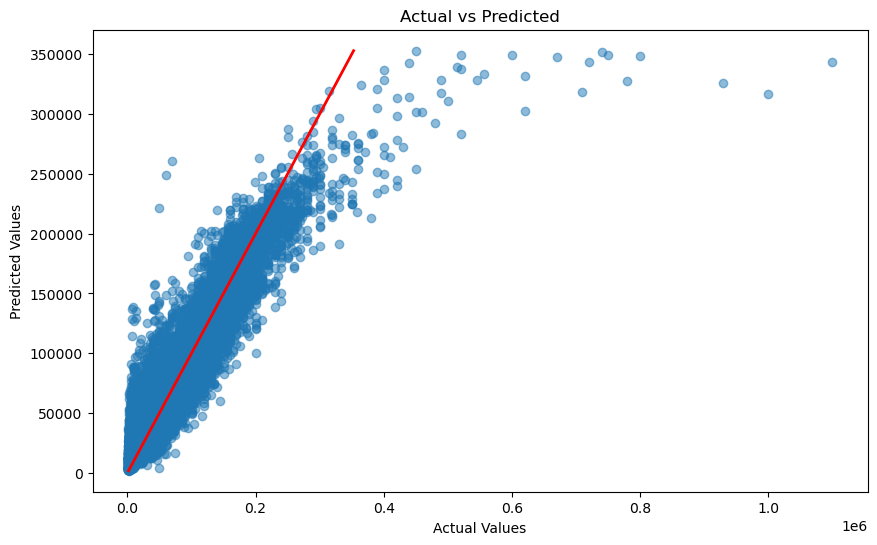

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, xgb_val_pred, alpha=0.5)
plt.plot([xgb_val_pred.min(), xgb_val_pred.max()], [xgb_val_pred.min(), xgb_val_pred.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted')
plt.show()

In [51]:
count_above_500000 = np.sum(xgb_test_pred >= 100000)
count_above_500000

np.int64(3636)

### LightGBM

In [36]:
# LightGBM 모델 초기화
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# 콜백 함수 정의
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

# 모델 학습
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[print_evaluation(period=100)]
)

# 검증 및 테스트 세트에 대한 예측
lgb_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
lgb_test_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4495
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 22
[LightGBM] [Info] Start training from score 38156.059948
[100] Train MAE: 4135.6540, Val MAE: 4151.4520
[200] Train MAE: 4010.5261, Val MAE: 4035.0188
[300] Train MAE: 3965.6523, Val MAE: 3996.6422
[400] Train MAE: 3935.0617, Val MAE: 3971.8657
[500] Train MAE: 3910.3120, Val MAE: 3952.7632


In [50]:
count_above_500000 = np.sum(lgb_test_pred >= 100000)
count_above_500000

np.int64(3765)

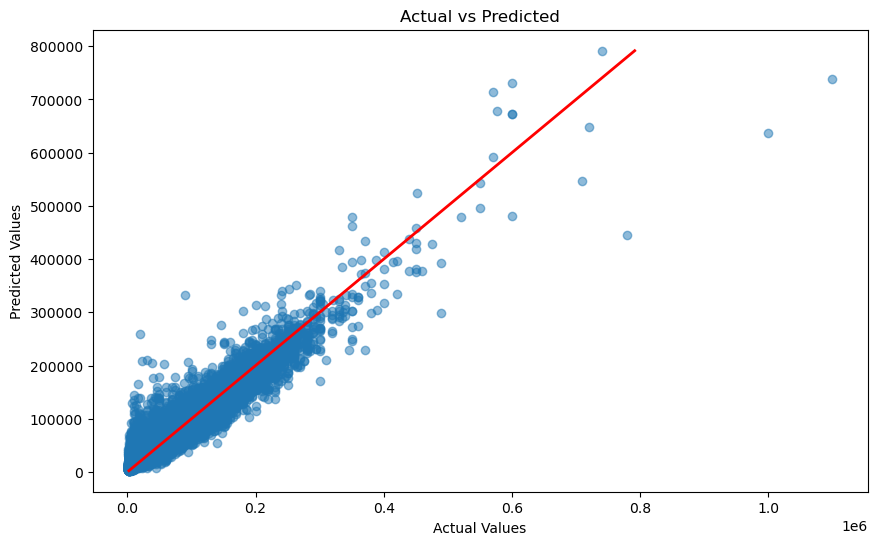

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val,lgb_val_pred, alpha=0.5)
plt.plot([lgb_val_pred.min(), lgb_val_pred.max()], [lgb_val_pred.min(), lgb_val_pred.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted')
plt.show()

### Random Forest

In [18]:
# 랜덤 포레스트 모델 초기화
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
)

# 모델 학습
rf_model.fit(X_train, y_train)

# 학습 세트에 대한 예측
rf_train_pred = rf_model.predict(X_train)

# 검증 세트에 대한 예측
rf_val_pred = rf_model.predict(X_val)

# 테스트 세트에 대한 예측
rf_test_pred = rf_model.predict(X_test)


# 학습 세트의 MAE 계산
train_mae = mean_absolute_error(y_train, rf_train_pred)
print(f"Train MAE: {train_mae:.4f}")

# 검증 세트의 MAE 계산
val_mae = mean_absolute_error(y_val, rf_val_pred)
print(f"Validation MAE: {val_mae:.4f}")

Train MAE: 4022.8751
Validation MAE: 4043.2896


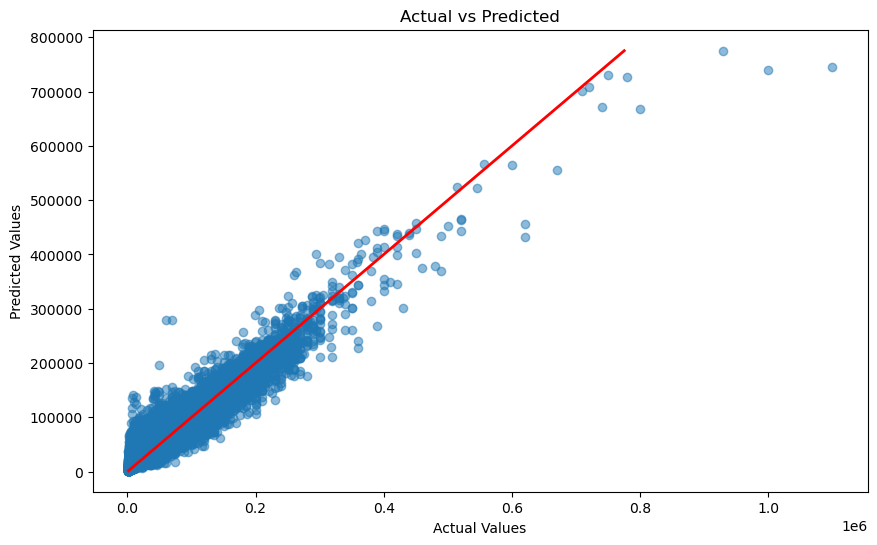

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_val_pred, alpha=0.5)
plt.plot([rf_val_pred.min(), rf_val_pred.max()], [rf_val_pred.min(), rf_val_pred.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted')
plt.show()

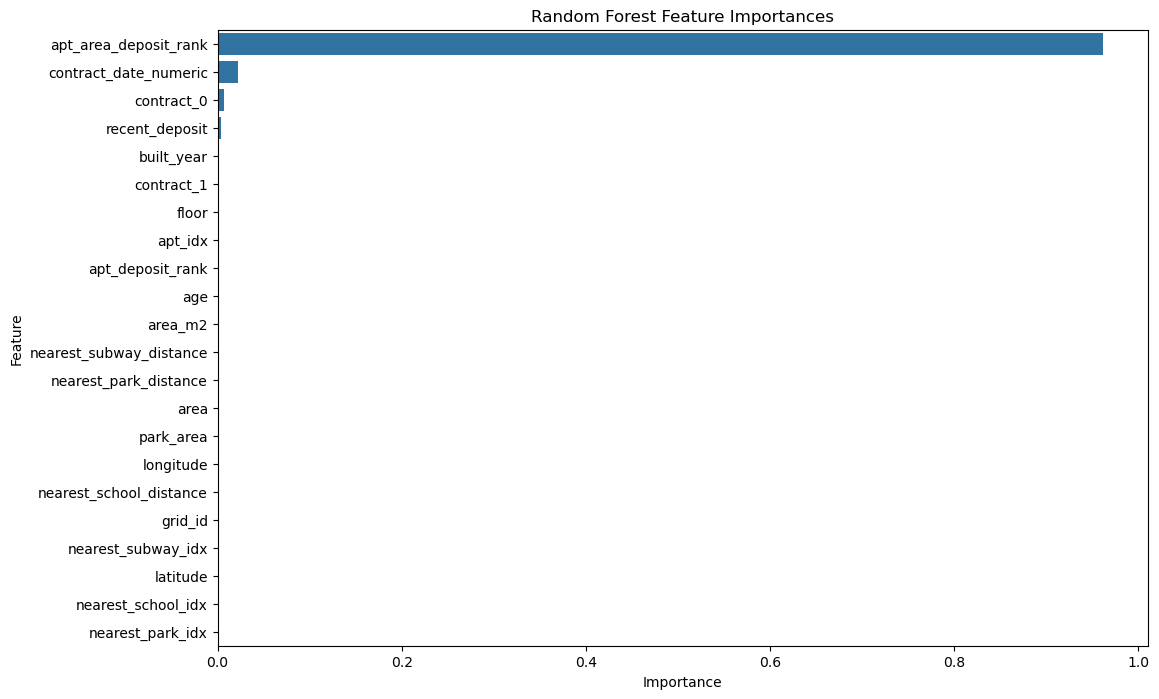

In [15]:
# 피처 임포턴스 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 피처 임포턴스를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importances')
plt.show()

### Gradient Boosting Regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting 회귀 모델 초기화
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 모델 학습
gb_model.fit(X_train, y_train)

# 검증 및 테스트 세트에 대한 예측
gb_val_pred = gb_model.predict(X_val)
gb_test_pred = gb_model.predict(X_test)

# 학습 세트의 MAE 계산
gb_train_pred = gb_model.predict(X_train)
train_mae = mean_absolute_error(y_train, gb_train_pred)
print(f"Train MAE: {train_mae:.4f}")

# 검증 세트의 MAE 계산
val_mae = mean_absolute_error(y_val, gb_val_pred)
print(f"Validation MAE: {val_mae:.4f}")

Train MAE: 4240.1116
Validation MAE: 4230.3626


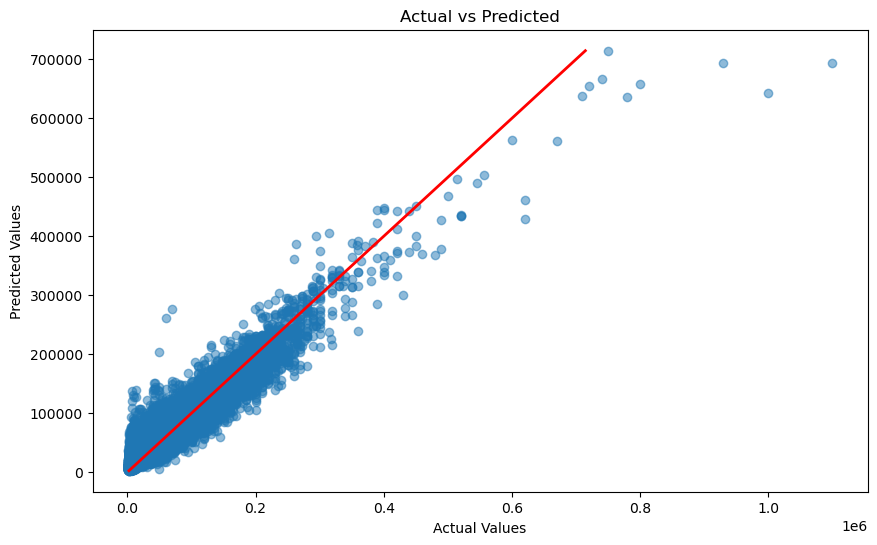

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, gb_val_pred, alpha=0.5)
plt.plot([gb_val_pred.min(), gb_val_pred.max()], [gb_val_pred.min(), gb_val_pred.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted')
plt.show()

### ElasticNet Regressor

In [24]:
from sklearn.linear_model import ElasticNet

# ElasticNet 회귀 모델 초기화
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42, max_iter=10000)

# 모델 학습
elastic_model.fit(X_train, y_train)

# 검증 및 테스트 세트에 대한 예측
elastic_val_pred = elastic_model.predict(X_val)
elastic_test_pred = elastic_model.predict(X_test)

# 학습 세트의 MAE 계산
elastic_train_pred = elastic_model.predict(X_train)
train_mae = mean_absolute_error(y_train, elastic_train_pred)
print(f"Train MAE: {train_mae:.4f}")

# 검증 세트의 MAE 계산
val_mae = mean_absolute_error(y_val, elastic_val_pred)
print(f"Validation MAE: {val_mae:.4f}")

Train MAE: 5622.0763
Validation MAE: 5600.1763


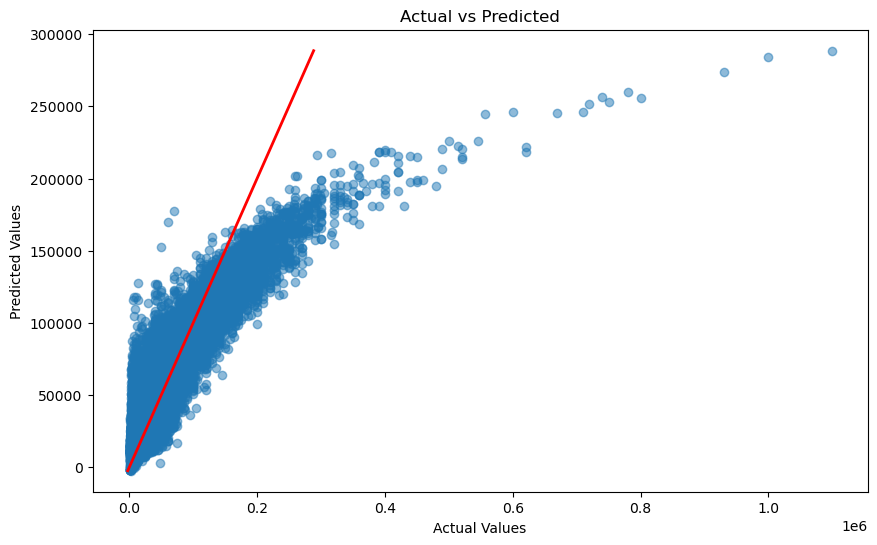

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, elastic_val_pred, alpha=0.5)
plt.plot([elastic_val_pred.min(), elastic_val_pred.max()], [elastic_val_pred.min(), elastic_val_pred.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted')
plt.show()

### Stacking

In [18]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 검증 세트의 예측을 메타 모델의 입력으로 결합
meta_X = np.column_stack((xgb_val_pred, lgb_val_pred, rf_val_pred, gb_val_pred))
meta_y = y_val

# 테스트 세트의 예측을 메타 모델의 입력으로 결합
meta_X_test = np.column_stack((xgb_test_pred, lgb_test_pred, rf_test_pred, gb_test_pred))

# LGBMRegressor 메타 모델의 하이퍼파라미터 탐색 공간 정의
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [5, 10, 20, 30],
    'min_split_gain' : [0.2, 0.3, 0.5],
}

# LGBMRegressor 메타 모델 초기화
base_model = LGBMRegressor(random_state=42, force_row_wise=True)

# RandomizedSearchCV를 사용한 하이퍼파라미터 튜닝
kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(base_model, param_distributions=param_dist, 
                                   n_iter=50, cv=kf, scoring='neg_mean_absolute_error', 
                                   random_state=42, n_jobs=-1)

# 하이퍼파라미터 튜닝 수행
random_search.fit(meta_X, meta_y)

# 최적의 모델 선택
best_model = random_search.best_estimator_

# 교차 검증을 사용한 메타 모델의 성능 평가
cv_predictions = cross_val_predict(best_model, meta_X, meta_y, cv=kf)
cv_mae = mean_absolute_error(meta_y, cv_predictions)
print(f"Meta Model Cross-Validation MAE: {cv_mae:.4f}")

# 전체 데이터로 최종 모델 학습
best_model.fit(meta_X, meta_y)

# 최종 예측 수행
final_pred = best_model.predict(meta_X_test)

# 특성 중요도 출력
feature_importance = best_model.feature_importances_
feature_names = ['XGBoost', 'LightGBM', 'RandomForest', 'GradientBoosting', 'ElasticNet Regressor']
for name, importance in zip(feature_names, feature_importance):
    print(f"{name} importance: {importance:.4f}")

[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 360246, number of used features: 4
[LightGBM] [Info] Start training from score 38076.903966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [19]:
final_pred

array([22327.22889664,  7544.4337446 ,  7000.56065314, ...,
       44878.80828445, 36818.74645632, 38141.3089992 ])

In [20]:
# Create a DataFrame from y_pred with the same index as X_test
final_pred_df = pd.DataFrame(final_pred, index=range(len(final_pred)), columns=['deposit'])

# Display the DataFrame
final_pred_df.index.name = 'index'
final_pred_df

,deposit
index,
0,22327.228897
1,7544.433745
2,7000.560653
3,6999.374966
4,7000.560653
...,...
150167,37126.207316
150168,44088.351525
150169,44878.808284


In [21]:
final_pred_df['deposit'].mean()

np.float64(39136.96175915013)

In [23]:
final_pred_df.to_csv(os.path.join(submission_path, "v8_Stacking_XLRG_5_log_ss.csv"), index=True)

## XGB와 LGBM의 평균

In [24]:
# XGBoost와 LightGBM의 테스트 예측값을 평균내기
final_pred_avg = (xgb_test_pred + lgb_test_pred) / 2

# Create a DataFrame from the averaged predictions with the same index as X_test
final_pred_df2 = pd.DataFrame(final_pred_avg, index=range(len(final_pred_avg)), columns=['deposit'])

# Display the DataFrame
final_pred_df2.index.name = 'index'
final_pred_df2

,deposit
index,
0,22173.603518
1,7259.399896
2,6332.328751
3,6315.447267
4,6475.505575
...,...
150167,37308.279536
150168,43850.379036
150169,44677.882280


In [25]:
final_pred_df2['deposit'].mean()

np.float64(39092.24129546622)

In [26]:
final_pred_df2.to_csv(os.path.join(submission_path, "v8_avg_XL_log_ss.csv"), index=True)

In [53]:
tt = pd.read_csv(os.path.join(submission_path, "v8_avg_XL_log_ss.csv"))

In [60]:
tt[tt['deposit']>100000]

,index,deposit
7945,7945,123542.093769
7960,7960,104190.463519
7977,7977,107430.387283
7980,7980,100956.745793
8004,8004,114227.575677
...,...,...
144238,144238,110349.908567
144362,144362,113643.026780
144366,144366,100559.152684
144367,144367,100559.152684
